In [1]:
import os 

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold
import albumentations as A
from sklearn.model_selection import train_test_split
from tqdm import tqdm_g as tqdm
import time

In [4]:
MEAN = [0.485, 0.456, 0.406] 
STD = [0.229, 0.224, 0.225]
BATCH_SIZE = 256
HEIGHT = 32
WIDTH = 32
N_EPOCHS = 10
N_FOLDS = 5
N_WORKERS = 4
INIT_LR = 0.01
RANDOM_STATE = 47
DATASET_DIR = "./data/"
MODEL_PATH = "./models/"
N_FOLDS = 5
FOLD = 0
device = torch.device("cuda")

In [5]:
df = pd.read_csv(DATASET_DIR + "data.csv")
classes = df.character.unique()

idx2class = {i:class_name for i, class_name in enumerate(classes)}
class2idx = {class_name:i for i, class_name in enumerate(classes)}

df["character_id"] = df.character.map(class2idx)

skf = StratifiedKFold(N_FOLDS, shuffle = True, random_state = RANDOM_STATE)
for i_fold, (train_idx, val_idx) in enumerate(skf.split(df, df.character)):
    df.loc[val_idx, "fold"] = i_fold
df.fold = df.fold.astype(np.int)

In [6]:
class Albumentations():
    def __init__(self, augmentations):
        self.augmentations  = A.Compose(augmentations)
    def __call__(self, image):
        return self.augmentations(image = image)["image"]


In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, folds , mode, transform = None, transform_orig = None):
        df = df[df.fold.isin(folds)].reset_index(drop = True)
        self.images= df.drop(['character','fold', "character_id"], axis = 1).values
        self.labels = df['character_id'].values
        self.mode = mode
        self.transforms = transform
        self.transforms_orig = transform_orig
        
    def __len__(self):
        return self.images.shape[0]
    
    def __mode__(self):
        return self.mode
    
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        image = image.reshape((HEIGHT, WIDTH))
        image_orig = image.astype(np.float32).copy()
        if self.transforms:
            image = self.transforms(image)
        if self.transforms_orig:
            image_orig = self.transforms_orig(image)
        
        return torch.tensor(image), torch.tensor(image_orig), torch.tensor(label)

In [8]:
preprocess=[
    
]

augmentations = [
    A.PadIfNeeded(min_height=HEIGHT, min_width=WIDTH, border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255], always_apply=True),
    A.OneOf([
        A.ShiftScaleRotate(rotate_limit=30, border_mode=cv2.BORDER_CONSTANT, value=[0, 0, 0], mask_value=[255, 255, 255], always_apply=True),
    ], 0.5)
]
transforms_train = transforms.Compose([
    np.uint8,
    Albumentations(preprocess + augmentations),
    transforms.ToTensor(),
#     transforms.Normalize(mean = MEAN, std = STD)
])

transforms_val = transforms.Compose([
    np.uint8,
    Albumentations(preprocess),
    transforms.ToTensor(),
#     transforms.Normalize(mean = MEAN, std = STD)
    
])
transforms_orig = transforms.Compose([
    np.uint8,
    Albumentations(preprocess),
    transforms.ToTensor(),   
])


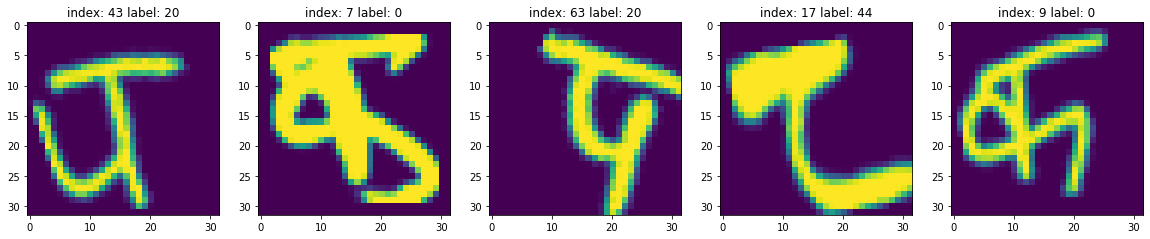

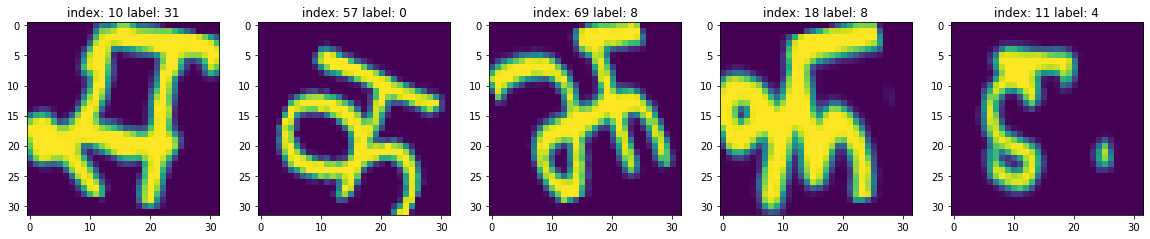

In [9]:
df_show = df.sample(n = 100)

dataset_show = Dataset( df_show, [0,1,2,3],"train",transforms_train, transforms_orig )

from pylab import rcParams
rcParams["figure.figsize"] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, img_orig, label = dataset_show[idx]
        axarr[p].imshow(img.transpose(0,1).transpose(1,2).squeeze())
        axarr[p].set_title("index: "+ str(idx)+" label: " + str(label.item()))

In [10]:
import pretrainedmodels
import torch.nn as nn
from torch.nn import functional as F


class nn_model(nn.Module):
    def __init__(self, pretrained):
        super(nn_model, self).__init__()

        if pretrained:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained = "imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained = None)

        self.front = nn.Conv2d(1, 3, (1, 1), stride= 1, padding = 0)
        self.l2 = nn.Linear(512, 47)

    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.front(x)
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        
        l2 = self.l2(x)

        return l2


In [11]:
def criterion(logits, targets):
    return nn.CrossEntropyLoss()(logits, targets)

In [12]:
def train_epoch(loader, optimizer):
    model.train()
    bar = tqdm(loader)
    train_loss = []
    for(data, data_orig, targets) in bar:
        optimizer.zero_grad()
        data, data_orig, targets = data.to(device), data_orig.to(device),targets.to(device)
        
        logits = model(data)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-20:])/min(len(train_loss), 20)

        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))

    return train_loss

def val_epoch(loader):
    model.eval()
    val_loss = []
    outputs = []
    LOGITS = []
    acc = 0
    pred = []
    with torch.no_grad():
        for (data, data_orig, target) in tqdm(loader):
            data, data_orig, target = data.to(device), data_orig.to(device), target.to(device)
            logits = model(data)
            loss = criterion(logits, target)
            pred = nn.Softmax(logits).argmax(1).detach()
            outputs.append(pred)
            acc += (target == pred).sum().detach().cpu().numpy()
            if get_output:
                LOGITS.append(logits)
            val_loss.append(loss.cpu().numpy())
        val_loss = np.mean(val_loss)
        acc /= len(dataset_valid)

    return val_loss, acc, score


In [13]:
for i in range(N_FOLDS):
    print(df[df.fold == i].character_id.value_counts())

31    400
35    400
38    400
22    400
6     400
37    400
21    400
5     400
36    400
20    400
4     400
19    400
15    400
3     400
34    400
18    400
2     400
33    400
17    400
1     400
32    400
16    400
7     400
23    400
39    400
8     400
30    400
14    400
45    400
29    400
13    400
44    400
28    400
12    400
43    400
27    400
11    400
42    400
26    400
10    400
41    400
25    400
9     400
40    400
24    400
0     400
Name: character_id, dtype: int64
31    400
35    400
38    400
22    400
6     400
37    400
21    400
5     400
36    400
20    400
4     400
19    400
15    400
3     400
34    400
18    400
2     400
33    400
17    400
1     400
32    400
16    400
7     400
23    400
39    400
8     400
30    400
14    400
45    400
29    400
13    400
44    400
28    400
12    400
43    400
27    400
11    400
42    400
26    400
10    400
41    400
25    400
9     400
40    400
24    400
0     400
Name: character_id, dtype: int64
31    400
35  

In [14]:
n_folds = N_FOLDS
record = [{'train_loss': [], 'val_loss': [], "score": []} for x in range(n_folds)]

fold = FOLD
i_fold = fold
folds = [i for i in range(n_folds)]
train_idx, valid_idx = np.where((df['fold'] != i_fold))[0], np.where((df['fold'] == i_fold))[0]

train_folds = []
val_folds = []
for i in range(n_folds):
    if i == fold:
        val_folds.append(i)
    else:
        train_folds.append(i)

dataset_train = Dataset( df, train_folds,"train",transforms_train, transforms_orig )

dataset_valid = Dataset( df, val_folds ,"val",transforms_val, transforms_orig )

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True,num_workers=0)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False, sampler=None, num_workers=0)

model = nn_model(pretrained= True)
model = model.to(device)

max_acc = 0
model_file = f"{MODEL_PATH}resnet34_pretrained_best_fold_{i_fold}.pth"

optimizer = torch.optim.Adam(model.parameters(), lr = INIT_LR)

In [15]:
for epoch in range(1, N_EPOCHS+1):
    print(time.ctime(), 'Epoch:', epoch)
 
    train_loss = train_epoch(train_loader, optimizer)
    val_loss, acc = val_epoch(valid_loader)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}'
    
    print(content)
    with open(f"log_resnet34.txt", "a") as appender:
        appender.write(content + "\n")
    
    if (epoch) % 125==0 or (epoch+1)%120 == 0:
        print(f"Saving model on epoch {epoch}")
        torch.save(model.state_dict(), f'{MODEL_PATH}resnet34_{epoch}_fold{i_fold}.pth')

    if acc > max_acc:
        max_acc = acc
        print('acc ({:.6f} --> {:.6f}).  Saving model ...'.format(max_acc, acc))
        torch.save(model.state_dict(), model_file)

torch.save(model.state_dict(), os.path.join(f'resnet34_model_fold{i_fold}.pth'))

Sun May 31 17:47:15 2020 Epoch: 1


KeyboardInterrupt: 